# Feature Extraction

This notebook goes through the feature extraction pipeline:

- data import and event class instantiation
- image preprocessing
- feature extraction

In [1]:
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
import sys
import os

print("Current working directory: ", os.getcwd())
sys.path.append(os.path.abspath('../ANN-code'))

from bb_event import Event
from image_preprocessing import *
from image_analysis import *
from feature_extraction import *
from data_methods import *


from ipywidgets import interact
from ipywidgets import interact, FloatSlider
from scipy.interpolate import splprep, splev


Current working directory:  /Users/benstevens/MIGDAL/NR-ANN/notebooks


## Data import

In [2]:
# set random seed
# np.random.seed(2)

# choose data path
data_path = ["../ANN-code/Data/im0"]
# data_path = ["../../../../tmarley/GEM_ITO/run/im0"
#              "../../../../tmarley/GEM_ITO/run/im1/C",
#              "../../../../tmarley/GEM_ITO/run/im1/F",
#              "../../../../tmarley/GEM_ITO/run/im2",
#              "../../../../tmarley/GEM_ITO/run/im3",
#              "../../../../tmarley/GEM_ITO/run/im4",]

file_paths = create_file_paths(data_path)
events = []

# take only 1000 images
file_paths = np.random.choice(file_paths, size=1000, replace=True)
for file in file_paths:
    events.append(Event(file, np.load(file)))

print("Number of events loaded: ", len(events))

100%|██████████| 2027/2027 [00:00<00:00, 1594496.29it/s]


Number of events loaded:  1000


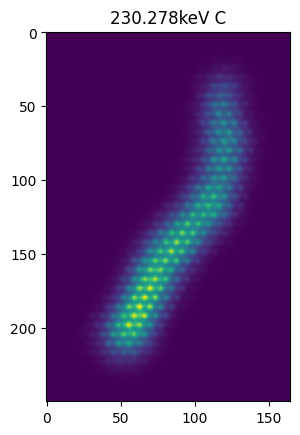

In [3]:
# sample random event
event = np.random.choice(events, 1, replace=True)[0]

# plot image before processing
event.plot_image()

## Image preprocessing

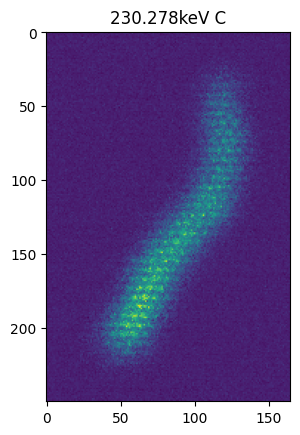

In [4]:
# add noise to image

# import master_dark, example_dark_list

dark_dir = "../ANN-code/Data/darks"
dark_list_number = 0 
m_dark = np.load(f"{dark_dir}/master_dark_1x1.npy")
example_dark_list = np.load(
    f"{dark_dir}/quest_std_dark_{dark_list_number}.npy"
)

event.image = noise_adder(event.image, m_dark, example_dark_list)

# plot noisy image
event.plot_image()

# this is now how an event would look realistically(ish)

Here is a widget to look at smoothing

In [5]:
unsmoothed_image = event.image.copy()

# Interactive widget to vary smoothing_sigma
def interactive_smoothing(sigma):
    smoothing_widget(unsmoothed_image, sigma)

# Create the slider and link it to the function
interact(interactive_smoothing, sigma=widgets.FloatSlider(value=1.0, min=0.0, max=10.0, step=0.1, description="Smoothing σ"))

interactive(children=(FloatSlider(value=1.0, description='Smoothing σ', max=10.0), Output()), _dom_classes=('w…

<function __main__.interactive_smoothing(sigma)>

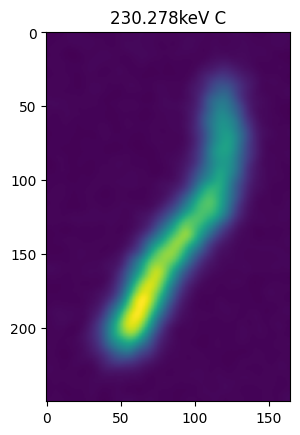

In [6]:
# using a fixed sigma value

sigma = 3.5
event.image = gaussian_smoothing(event.image, sigma)

# plot smoothed image
event.plot_image()

In [7]:
# more smootihng visualisation

smoothing_widget_3d(unsmoothed_image)

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Smoothing σ:', max=10.0), O…

In [8]:
# threshold widget test

def interactive_image_threshold(event_image):
    """
    Creates an interactive widget to vary the threshold percentile for an image.

    Parameters:
    ----------
    event_image : np.ndarray
        The image from the Event object to threshold.
    """

    interact(
        lambda threshold_percentile: image_threshold_widget(event_image, threshold_percentile),
        threshold_percentile=FloatSlider(value=95, min=0, max=100, step=1, description="Percentile")
    )


interactive_image_threshold(event.image)


interactive(children=(FloatSlider(value=95.0, description='Percentile', step=1.0), Output()), _dom_classes=('w…

Demonstrates the functionality of thresholding to get more accurate intensity and other features. however this requires a choice of fixed percentile which is not natural for all of the energy range. therefore we don't use this for feature extraction yet

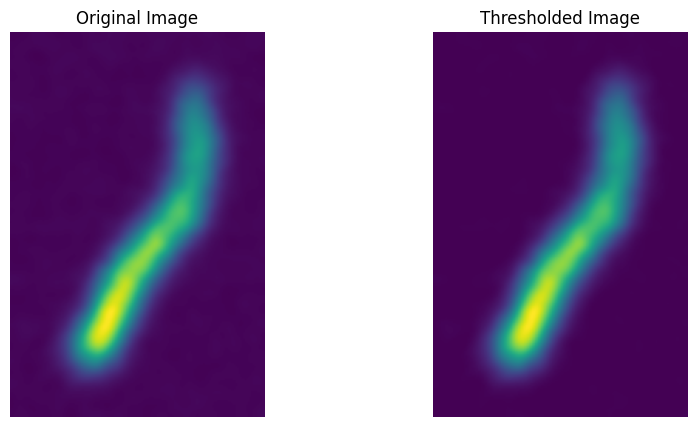

In [9]:
# threshold with fixed percentile
threshold_percentile = 50

threshold = np.percentile(event.image, threshold_percentile)
thresholded_image = np.where(event.image > threshold, event.image, 0)

# plot thresholded image next to original
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(event.image, cmap="viridis")
ax[0].set_title("Original Image")
ax[0].axis("off")
ax[1].imshow(thresholded_image, cmap="viridis")
ax[1].set_title("Thresholded Image")
ax[1].axis("off")
plt.show()



In [10]:
# widget to look at combined operations

combined_widget(unsmoothed_image, axis=True)

interactive(children=(FloatSlider(value=1.0, description='Smoothing σ', max=10.0), FloatSlider(value=95.0, des…

In [11]:
# this cell generates a gif of the threshold plot changing for a fixed smoothing sigma

# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.ndimage import gaussian_filter
# import imageio
# import os
# from image_preprocessing import plot_axis_widget
# from feature_extraction import extract_axis

# def generate_threshold_gif(image: np.ndarray, sigma: float, output_path: str):
#     """
#     Generates a GIF of the threshold plot changing for a fixed smoothing sigma.

#     Parameters:
#     ----------
#     image : np.ndarray
#         Input 2D array representing the image.
#     sigma : float
#         Fixed standard deviation for Gaussian smoothing.
#     output_path : str
#         File path to save the resulting GIF.
#     """
#     # Apply Gaussian smoothing
#     smoothed_image = gaussian_filter(image, sigma=sigma)

#     # Create a range of threshold percentiles
#     threshold_percentiles = np.linspace(60, 99.9, 150)  # Adjust the range and steps as needed

#     # List to store file paths of frames
#     frames = []

#     for i, threshold_percentile in enumerate(threshold_percentiles):
#         # Apply thresholding
#         threshold_value = np.percentile(smoothed_image, threshold_percentile)
#         thresholded_image = np.where(smoothed_image >= threshold_value, smoothed_image, 0)

#         # Extract the principal axis for the thresholded image
#         principal_axis, centroid = extract_axis(thresholded_image)

#         # Plot the thresholded image with principal axis
#         fig, ax = plt.subplots(figsize=(6, 6))
#         plot_axis_widget(thresholded_image, principal_axis, centroid)
#         ax.set_title(f"Thresholded Image (> {threshold_percentile:.1f}th Percentile)")

#         # Save the frame as a temporary file
#         frame_path = f"frame_{i:03d}.png"
#         plt.savefig(frame_path, dpi=100, bbox_inches="tight")
#         plt.close(fig)  # Ensure the figure is closed to prevent memory issues

#         frames.append(frame_path)

#     # Combine frames into a GIF
#     images = [imageio.imread(frame) for frame in frames]
#     imageio.mimsave(output_path, images, duration=0.1)  # Adjust duration for speed

#     # Clean up temporary files
#     for frame in frames:
#         os.remove(frame)

# # Example usage
# # Assuming `event_image` is your input image
# generate_threshold_gif(unsmoothed_image, sigma=3.5, output_path="threshold_plot.gif")
# generate_threshold_gif(unsmoothed_image, sigma=0, output_path="unsmoothed_threshold_plot.gif")

## Feature extraction

#### basic features of image

In [12]:
# save the processed image as a png (if needed)
plt.imsave("processed_event.png", event.image, cmap="viridis")


In [13]:
# first consider simple features 
# extracting with the image after it has had noise added and smoothed.

total_energy = extract_energy_deposition(event.image)
max_intensity = extract_max_pixel_intensity(event.image)

print(f"Total energy deposition: {total_energy}")
print(f"Max pixel intensity: {max_intensity}")

Total energy deposition: 772245.8128662114
Max pixel intensity: 196.64795079067002


#### principal axis using eigendecomposition 

Principal axis: [ 0.4692625  -0.88305872]


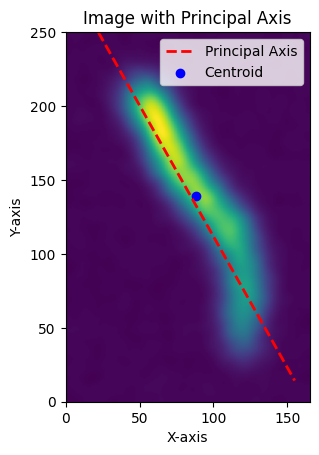

In [14]:
# extract axis and centroid

axis, centroid = extract_axis(event.image, method="eigen")
print(f"Principal axis: {axis}")

# plot image with principal axis
plot_axis(event.image, axis, centroid)


#### grid interpolation

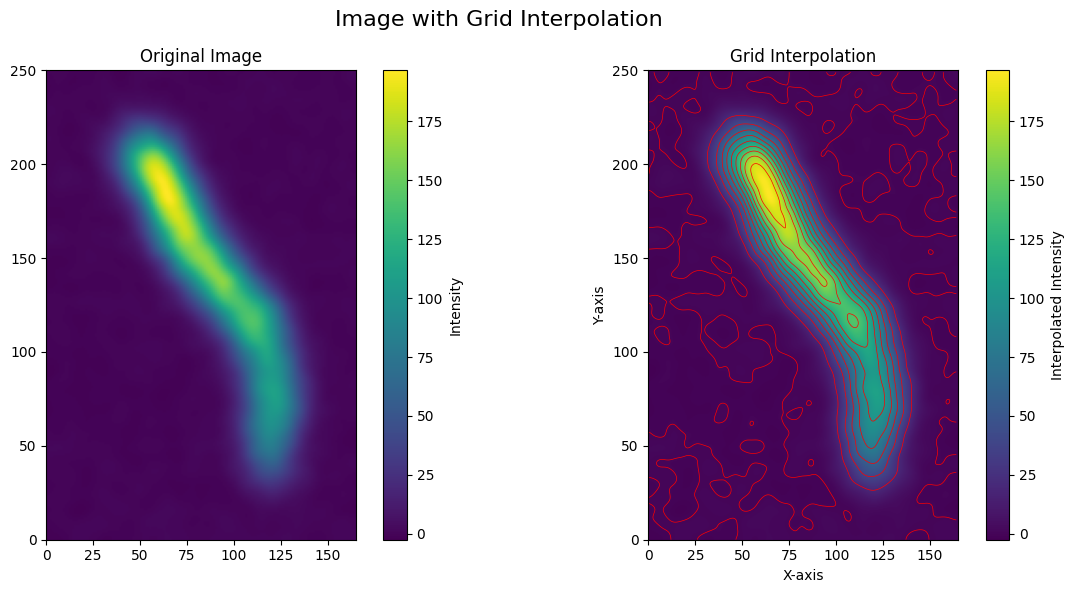

In [15]:
# interesting grid interpolation method

grid_x, grid_y, grid_z = extract_intensity_contour(event.image)
plot_intensity_contour(event.image, grid_x, grid_y, grid_z)

#### recoil angles

In [16]:
recoil_angle = extract_recoil_angle(axis)

print(recoil_angle)

62.01356540898141


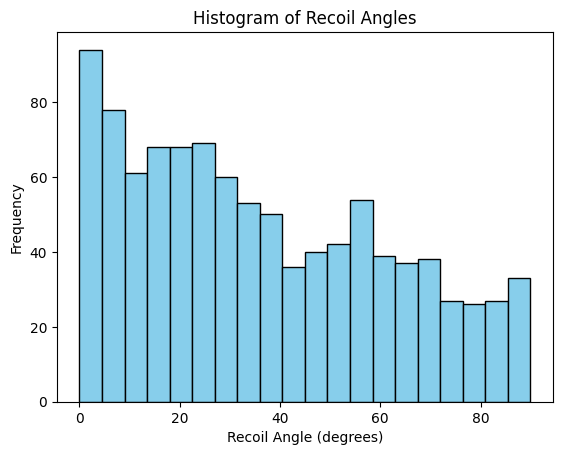

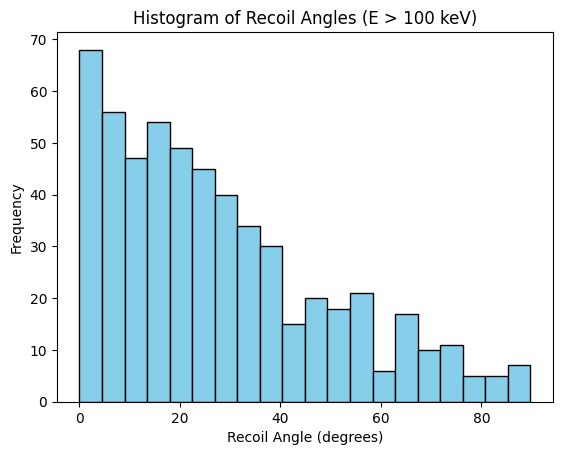

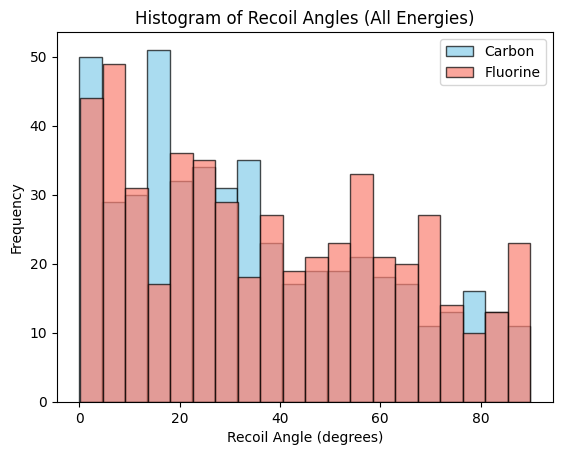

In [17]:
# find recoil angle for all events

recoil_angles = []

for event in events:
    axis, _ = extract_axis(event.image, method="eigen")
    recoil_angle = extract_recoil_angle(axis)
    recoil_angles.append(recoil_angle)

# histogram of recoil angles

plt.hist(recoil_angles, bins=20, color="skyblue", edgecolor="black")
plt.xlabel("Recoil Angle (degrees)")
plt.ylabel("Frequency")
plt.title("Histogram of Recoil Angles")
plt.show()


# plot the same histogram, but only for events with energy > 100keV

recoil_angles = []

for event in events:

    energy = event.get_energy_from_name()

    if energy > 100:
        axis, _ = extract_axis(event.image, method="eigen")
        recoil_angle = extract_recoil_angle(axis)
        recoil_angles.append(recoil_angle)

plt.hist(recoil_angles, bins=20, color="skyblue", edgecolor="black")
plt.xlabel("Recoil Angle (degrees)")
plt.ylabel("Frequency")
plt.title("Histogram of Recoil Angles (E > 100 keV)")
plt.show()


# now do a histogram, but distinguish between carbon and fluorine events (for all energy ranges)

carbon_recoil_angles = []
fluorine_recoil_angles = []

for event in events:
    
    axis, _ = extract_axis(event.image, method="eigen")
    recoil_angle = extract_recoil_angle(axis)
    
    if "C" in event.name:
        carbon_recoil_angles.append(recoil_angle)
    elif "F" in event.name:
        fluorine_recoil_angles.append(recoil_angle)

plt.hist(carbon_recoil_angles, bins=20, color="skyblue", edgecolor="black", alpha=0.7, label="Carbon")
plt.hist(fluorine_recoil_angles, bins=20, color="salmon", edgecolor="black", alpha=0.7, label="Fluorine")
plt.xlabel("Recoil Angle (degrees)")
plt.ylabel("Frequency")
plt.title("Histogram of Recoil Angles (All Energies)")
plt.legend()
plt.show()



#### spline interpolation

In [18]:
# plot spline

#plot image without spline
# event.plot_image()
# x_spline, y_spline = extract_spline(event.image, smoothing=0.5, resolution=500)
# plot_spline(event.image, x_spline, y_spline)

# given up on this for now...

#### intensity profiles (dE/dx)

In [19]:
# looking at intensity profiles using the 'thin_intensity_profile' method.

intensity_profile_widget(unsmoothed_image)


interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Smoothing σ:', max=10.0), O…

In [20]:
import imageio

def create_smoothing_gif(image: np.ndarray, output_path: str, sigma_values: list):
    """
    Creates a GIF showing the effect of increasing Gaussian smoothing on an image.

    Parameters:
        image (numpy.ndarray): 2D array representing the unsmoothed image.
        output_path (str): Path to save the generated GIF.
        sigma_values (list): List of sigma values for Gaussian smoothing.

    Returns:
        None
    """
    frames = []
    for sigma in sigma_values:
        smoothed_image = gaussian_smoothing(image, sigma)

        # Create a figure for the current frame
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Plot the smoothed image
        axes[0].imshow(smoothed_image, cmap='viridis', origin='lower')
        axes[0].set_title(f"Smoothed Image (Sigma={sigma:.1f})")
        axes[0].axis('off')

        # Extract and plot the intensity profile
        distances, intensities = extract_intensity_profile(smoothed_image, plot=False)
        axes[1].plot(distances, intensities, label="Intensity")
        axes[1].axvline(0, color='red', linestyle='--', label='Centroid')
        axes[1].set_title("Intensity Along Principal Axis")
        axes[1].set_xlabel("Distance Along Principal Axis")
        axes[1].set_ylabel("Intensity")
        axes[1].legend()
        axes[1].grid()

        # Convert the figure to a numpy array
        fig.canvas.draw()
        frame = np.frombuffer(fig.canvas.tostring_argb(), dtype='uint8')
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        frame = frame[:, :, [1, 2, 3]]  # Convert ARGB to RGB
        frames.append(frame)
        plt.close(fig)

    # Save all frames as a GIF
    imageio.mimsave(output_path, frames, fps=30)
    print(f"GIF saved to {output_path}")

# sigma_values = np.linspace(0, 10.0, 300)
# create_smoothing_gif(unsmoothed_image, 'outputs/intensity_profile_smoothing.gif', sigma_values=sigma_values)

need to compare methods now ...

#### length extraction from intensity profile

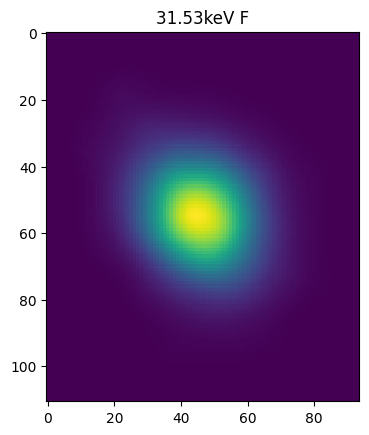

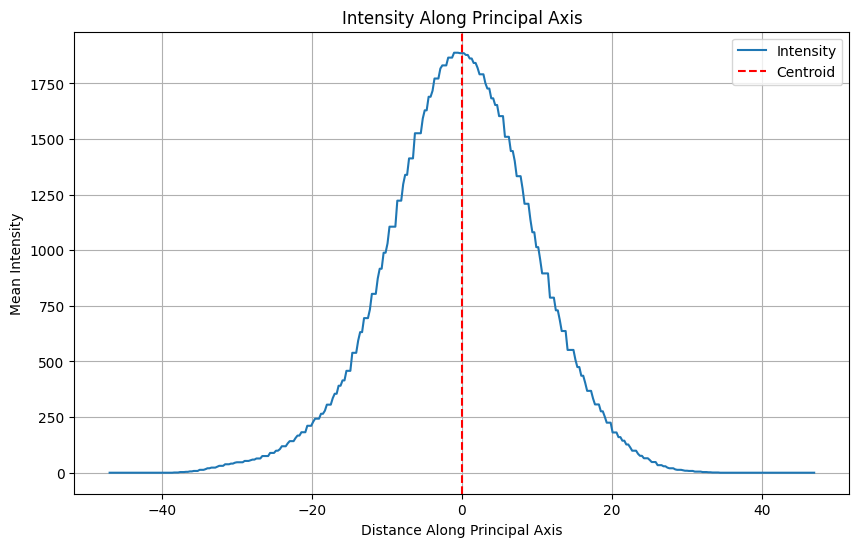

48.04444444444445


In [21]:
event.image = gaussian_smoothing(event.image, 3.5)
event.plot_image()

# plot intensity profile
distances, intensities = extract_intensity_profile(event.image, plot=True)

# extract length
length = extract_length(event.image, energy_percentile=50)
print(length)

In [22]:
# visualise and test the length extraction

recoil_length_widget(event.image)


interactive(children=(FloatSlider(value=50.0, continuous_update=False, description='Threshold (%)', step=1.0),…

#### intensity profile features